# League of Legends Project - Elo System

- The purpose of this notebook is to create an elo system for predicting games.
- Rather than simply using the categorical data of the team, player, and champion names, as a feature in a machine learning model, an elo system works chronologically and so doesn't use the results of games that hasn't happened yet to find the impact of a team on the result of the game.
- I will use the teams, the players and the champions in this elo system, each with their own rating.
- The results of the elo system can then be used as a feature in the machine learning models in the LoL_Predictions notebook.

### What is an elo system?

An Elo System is a statistical method for calculating the relative strength of teams in sports.  I am using it because it doesn't assume that the strength of the team is constant, but that teams fluctuate, and so the Elo Ratings of teams within the system change depending on their previous results.

In an elo system, each team has a rating, when 2 teams play each other, the winning team's rating increases and the losing team's decreases.
The size of this increase is determined by the difference in the ratings between the 2 teams.

The larger the value of:<br>
losing team rating - winning team rating<br>
the larger the change in rating.

And the winning team's rating change is the exact opposite of the losing team's rating change.

Each team's rating is therefore changed after every game they play, and the ratings slowly move towards their "optimal" or "true" rating for that time.

My elo system will calculate the overall team rating as a composite of each player's rating, the team/organisation rating and a rating for each champion selected.

An explanation of the formula to calculate the elo system is located where the formula is, later in this notebook.

# Step 1: Clean the Data

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Reading in the dataframe that was pickled in the LoL_Data_Exploration Notebook

In [2]:
dflol = pd.read_pickle("dflol.pkl")

In [3]:
dflol.head()

,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,1,...,206.0,76.0,-512.0,-18.0,3.0,4.0,0.0,1.0,2.0,2.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,2,...,140.0,-888.0,351.0,-42.0,0.0,5.0,3.0,2.0,1.0,1.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,3,...,225.0,621.0,733.0,8.0,1.0,5.0,1.0,1.0,2.0,0.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,4,...,161.0,3265.0,1950.0,50.0,6.0,2.0,0.0,0.0,0.0,4.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,5,...,28.0,1780.0,2397.0,-19.0,0.0,7.0,0.0,0.0,1.0,3.0


Confirming that the dataset is already in chronological order

In [4]:
dftime = dflol.loc[dflol["participantid"] == 200, ["date", "year"]] # Only selecting 1 row (out of 12) per game
len(dftime["date"][dftime["date"] < dftime["date"].shift()]) # Checking how many games happened before the game above them in the dataset

0

In [5]:
dflol = dflol[["side", "gamelength", "year", "position", "playerid", "teamid", "earned gpm", "result"]]

Dropping columns that are not needed for the elo system

In [6]:
# Columns selected are the year, gameid, side, position, playerid, teamid, earned gpm, and result.
dflol.head(12)

,side,gamelength,year,position,playerid,teamid,earned gpm,result
gameid,,,,,,,,
TRLH3/33,Blue,1924,2014,top,oe:player:e4e943fa882367a96fb2a365de4e28c,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,235.1040,1
TRLH3/33,Blue,1924,2014,jng,oe:player:e4cd1e7b68ee6b595a6e4c7cd2c56d8,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,191.8815,1
TRLH3/33,Blue,1924,2014,mid,oe:player:5d69aabb447fa09188638716fe549b6,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,330.6861,1
TRLH3/33,Blue,1924,2014,bot,oe:player:d8362fe0d38ca0e70953ed957deaa00,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,319.6466,1
TRLH3/33,Blue,1924,2014,sup,oe:player:5ebcf3b41dc66e5839da4c5f58bd907,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,158.5759,1
TRLH3/33,Red,1924,2014,top,oe:player:c248a757d55f7ba42f3ffa39f716687,oe:team:3e18c32708da93cf6bdbd1d20b76731,189.9168,0
TRLH3/33,Red,1924,2014,jng,oe:player:1c7db660fc268b1d2747939129d6101,oe:team:3e18c32708da93cf6bdbd1d20b76731,178.6279,0
TRLH3/33,Red,1924,2014,mid,oe:player:70f2e5e51d358b04a8485db5a382f1a,oe:team:3e18c32708da93cf6bdbd1d20b76731,209.8753,0
TRLH3/33,Red,1924,2014,bot,oe:player:0cd6ba51204139f1e54c05c7c07e154,oe:team:3e18c32708da93cf6bdbd1d20b76731,158.0457,0


### Dealing With Missing Values

In [7]:
dflol.isna().sum()

side               0
gamelength         0
year               0
position           0
playerid      174174
teamid         11706
earned gpm      2458
result             0
dtype: int64

In [8]:
# Setting the player's teamid to 0.
dflol.loc[dflol["position"] != "team", "teamid"] = 0
# Setting the team's playerid to 0.
dflol.loc[dflol["position"] == "team", "playerid"] = 0
# Filling in ID NaN values as "Unknown" players and teams
dflol.loc[:, ["playerid", "teamid"]] = dflol[["playerid", "teamid"]].fillna("Unknown")

# Dropping NaN values for earnedgold
dflol = dflol.dropna(subset="earned gpm")

In [9]:
dflol.dtypes

side          category
gamelength      uint16
year            uint16
position      category
playerid        object
teamid          object
earned gpm     float64
result           uint8
dtype: object

# Step 2: Data Engineering

In [10]:
# Factorizing "playerid", and "champion".
dflol["playerid"] = pd.factorize(dflol["playerid"])[0]
dflol["teamid"] = pd.factorize(dflol["teamid"])[0]

print(f"There are {dflol['playerid'].nunique()} unique players")
print(f"There are {dflol['teamid'].nunique()} unique teams")

There are 9655 unique players
There are 1834 unique teams


### Reshaping the DataFrame
I am reshaping the dataframe to ensure that for each game, there is only 1 column.

In [11]:
# Split the data into winners and losers and adding prefixes.  Because the winners and losers now have column prefixes, I can delete the "result" column.
win_df = dflol[dflol["result"] == 1].drop("result", axis=1).add_prefix("win_", axis=1)

# Because the rows will be combined, in order to prevent duplicate columns, I will delete "result", "side", and "year" from lose_df
lose_df = dflol[dflol["result"] == 0].drop(["result", "side", "gamelength", "year"], axis=1).add_prefix("lose_", axis=1)

In [12]:
win_df.head()

,win_side,win_gamelength,win_year,win_position,win_playerid,win_teamid,win_earned gpm
gameid,,,,,,,
TRLH3/33,Blue,1924,2014,top,0,0,235.1040
TRLH3/33,Blue,1924,2014,jng,1,0,191.8815
TRLH3/33,Blue,1924,2014,mid,2,0,330.6861
TRLH3/33,Blue,1924,2014,bot,3,0,319.6466
TRLH3/33,Blue,1924,2014,sup,4,0,158.5759


In [13]:
# Split the winners and losers into each position.
positions = ["top", "jng", "mid", "bot", "sup", "team"]
positions_list1, positions_list2 = [], []

for i in range(6):
    positions_list1.append(win_df[win_df["win_position"] == positions[i]])
    positions_list2.append(lose_df[lose_df["lose_position"] == positions[i]])

In [14]:
for i in range(len(positions_list1)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list1[i] = positions_list1[i].drop(["win_position"], axis=1)

    # Only keep 1 "win_side", "win_year", "win_gamelength" column.
    if i > 0:
        positions_list1[i] = positions_list1[i].drop(["win_side", "win_gamelength", "win_year"], axis=1)

    if i == 5:
        positions_list1[i] = positions_list1[i].drop(["win_playerid"], axis=1)
    else:
        positions_list1[i] = positions_list1[i].drop(["win_teamid", "win_earned gpm"], axis=1)

    # Add prefixes of the positions for the column names.
    new_columns1 = []
    for c in positions_list1[i].columns.to_list():
        c = positions[i] + "_" + c
        new_columns1.append(c)
    positions_list1[i].columns = new_columns1

In [15]:
for i in range(len(positions_list2)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list2[i] = positions_list2[i].drop(["lose_position"],
                                                 axis=1)

    if i == 5:
        positions_list2[i] = positions_list2[i].drop(["lose_playerid"], axis=1)
    else:
        positions_list2[i] = positions_list2[i].drop(["lose_teamid", "lose_earned gpm"], axis=1)

    # Add prefixes of the positions for the column names.
    new_columns2 = []
    for c in positions_list2[i].columns.to_list():
        c = positions[i] + "_" + c
        new_columns2.append(c)
    positions_list2[i].columns = new_columns2

In [16]:
# Merging the 12 dataframes into 1 dataframe.
elo_win_df = (reduce(lambda x, y: pd.merge(x,y, on="gameid"),positions_list1)
              .rename({"top_win_side":"side", "top_win_gamelength":"gamelength", "top_win_year":"year"}, axis=1))

elo_lose_df = reduce(lambda x, y: pd.merge(x,y, on="gameid"), positions_list2)

elo_df = pd.merge(elo_win_df, elo_lose_df, on="gameid")

Each column corresponds to a single game, with all of the relevant data for that game in just the 1 column (rather than the original 12).

### Margin of Victory

Unlike sports like football where the score (and therefore the goal difference) can establish the margin of victory, in League of Legends the results are binary, you either destroy their base or they destroy yours.

The classic way in LoL to define margin of victory is to use the gamelength.  Theoretically, the faster a team is able to win games, the better they should be.  However, teams play a variety of different playstyles and shouldn't be punished for playing slowly and safely.  From my own experience, some teams have the ability to play a faster game but prefer to take their time because they believe that playing safer increases their chances of victory.

To decide what feature to use for Margin of Victory (MOV), I have decided to reward teams for finishing quickly, whilst trying not to disadvantage teams that choose to take longer.

I have chosen the ratio of team earned GPM.  This is the amount of gold the winning team earns per minute divided by the amount of gold the losing team earns per minute.  (My EDA also showed that the earned gpm of a team was a strong indicator of the result.)  I will expand below on why I have chosen this feature.

In [17]:
# Creating the derivative feature team_earned_gpm_ratio
elo_df[f"team_earned_gpm_ratio"] = elo_df[f"team_win_earned gpm"]/elo_df[f"team_lose_earned gpm"]

elo_df = elo_df.drop([f"team_win_earned gpm", f"team_lose_earned gpm"], axis=1)

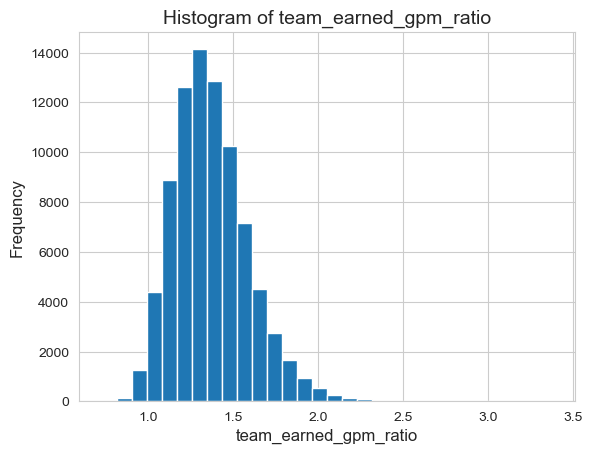

In [18]:
plt.hist(elo_df["team_earned_gpm_ratio"], bins=30)

plt.title("Histogram of team_earned_gpm_ratio", size=14)
plt.xlabel("team_earned_gpm_ratio", size=12)
plt.ylabel("Frequency", size=12)

plt.show()

I have used earned gpm rather than simply gold per minute because players get gold passively, every second and so by using earned gpm it is a more interpretable feature.

Earned GPM was also the most important feature in my preliminary linear regression model from LoL_Data_Exploration.

We can say that if a team has a ratio of 1.5, they have earned 50% more gold than the other team, and therefore have achieved 50% more "good things" in the game than their opponent.  (Gold earned by players for a huge variety of things, from killing champions, to turrets, to neutral objectives.)

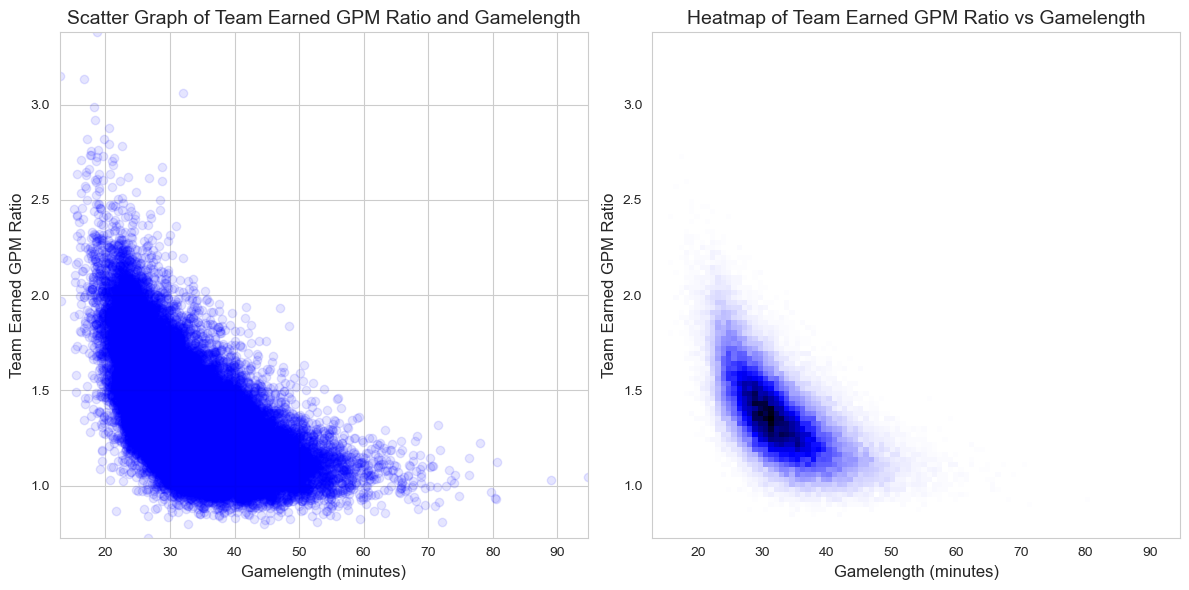

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(elo_df["gamelength"]/60,
               elo_df["team_earned_gpm_ratio"],
               alpha=0.1,
               color="blue")
axs[0].grid(True)
axs[0].set_title("Scatter Graph of Team Earned GPM Ratio and Gamelength", size=14)
axs[0].set_xlabel("Gamelength (minutes)", size=12)
axs[0].set_ylabel("Team Earned GPM Ratio", size=12)

axs[1].hist2d(elo_df["gamelength"] / 60,
              elo_df["team_earned_gpm_ratio"],
              bins=100,
              cmap=mcolors.LinearSegmentedColormap.from_list("", ["white", "blue", "black"]))
axs[1].grid(True)
axs[1].set_title("Heatmap of Team Earned GPM Ratio vs Gamelength", size=14)
axs[1].set_xlabel("Gamelength (minutes)", size=12)
axs[1].set_ylabel("Team Earned GPM Ratio", size=12)

xlim = (elo_df["gamelength"]/60).min(), (elo_df["gamelength"]/60).max()
ylim = elo_df["team_earned_gpm_ratio"].min(), elo_df["team_earned_gpm_ratio"].max()

axs[0].set_xlim(xlim)
axs[1].set_xlim(xlim)
axs[0].set_ylim(ylim)
axs[1].set_ylim(ylim)

plt.tight_layout()

The scatter graph of gamelength and team_earned_gpm_ratio is the best visual explanation of why I am using the feature.  Teams win games quickly have higher ratios, on average, than teams that win games slowly, so it rewards winning games quickly.  However, if a team wins more slowly, they can also have a large ratio.

Because one of the main ways to earn gold is through killing minions, which both teams do roughly evenly, when games are shorter, gold from turrets and kills, will make up a larger proportion of the total earned gold, and will be distributed disproportionately on the winning team, therefore increasing their ratio.

Therefore, the team_earned_gpm_ratio fits my criteria for the Margin of Victory feature.

### Preparing the Dataset for the Elo System

In [20]:
elo_df = elo_df.drop("gamelength", axis=1)
elo_df.head()

,side,year,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_teamid,top_lose_playerid,jng_lose_playerid,mid_lose_playerid,bot_lose_playerid,sup_lose_playerid,team_lose_teamid,team_earned_gpm_ratio
gameid,,,,,,,,,,,,,,,
TRLH3/33,Blue,2014,0,1,2,3,4,1,5,6,7,8,9,2,1.558697
TRLH3/44,Blue,2014,11,12,13,14,15,3,16,17,18,19,20,4,1.542978
TRLH3/76,Red,2014,0,1,2,3,4,1,16,17,18,19,20,4,1.198958
TRLH3/85,Blue,2014,5,6,7,8,9,2,11,12,13,14,15,3,1.944970
TRLH3/10072,Red,2014,26,27,28,29,30,6,21,22,23,24,25,5,1.631013


In [21]:
# Make the side column into 1s and -1s for the purposes of using it as a home field advantage adjuster.
elo_df["side"] = pd.factorize(elo_df["side"])[0]
elo_df["side"] = ((elo_df["side"] * -2) + 1)
elo_df["side"].head()

gameid
TRLH3/33       1
TRLH3/44       1
TRLH3/76      -1
TRLH3/85       1
TRLH3/10072   -1
Name: side, dtype: int64

In [22]:
print(f"There are {elo_df.shape[0]} games recorded in elo_df")

There are 82730 games recorded in elo_df


In order to have test dataset that is not trained on games that have not happened yet, I will split the test and train arrays manually, by date, rather than doing so randomly.

In [23]:
train_size = 65000
train_elo_df = elo_df.iloc[:train_size]
test_elo_df = elo_df.iloc[train_size:]
print(train_size/len(elo_df))

0.7856883838994319


# Step 3: Training the Elo System

### Elo update formula.
This formula calculates 2 things.

First, it calculates "$p$" which is the probability that the team that actually won will win.

&nbsp;&nbsp;&nbsp;&nbsp;$p = 1. / (1. + np.power(10, (loser\_elo - (winner\_elo + hfa)) / 400.))$

To do this, it applies the $hfa$, or home field advantage. This is a constant that either adds to, or takes away from the winning team's elo rating (only in the calculation) depending on whether the winning team was on Blue side.

&nbsp;&nbsp;&nbsp;&nbsp;$winner\_elo + hfa$

From the LoL_Data_Exploration notebook, we know that the team on Blue side wins games around 53% of the time, so there is a slight advantage that the elo system will include in its prediction.

After the $hfa$ is accounted for, I find out the difference between the losing team's and winning's team elo. This is then divided by 400.

&nbsp;&nbsp;&nbsp;&nbsp;$(loser\_elo - (winner\_elo + hfa)) / 400.$

This 400, is a fixed constant called the $elo\_width$. Changing the $elo\_width$ does not affect the system's predictions and is primarily an aesthetic feature. What it technically means is that if a team's rating is 400 larger than the other team, that team's probability of winning is 10x larger than the team with a rating 400 smaller.

This value is then used in: $1 / (1+ 10^x)$ as $x$.

This is an exponential decay function. The value of $p$ will never be above 1 or below 0. It plateaus around 1 and 0 so that very large differences in teams' ratings (larger than 600) don't have significantly larger probabilities than if the gap was just 400.

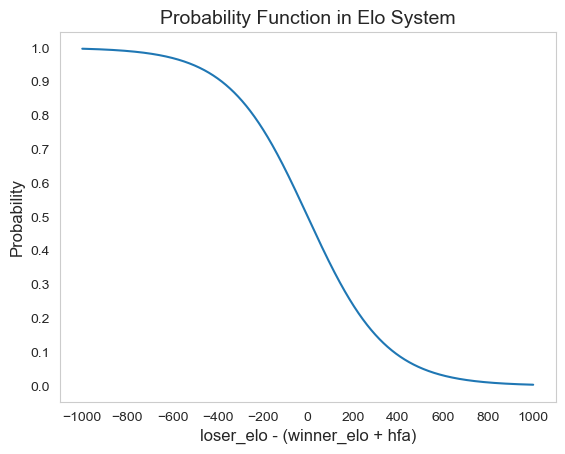

In [24]:
x = np.linspace(-1000,1000,2000)
y = 1. / (1. + np.power(10, x/400))
plt.plot(x, y)

plt.xticks(range(-1000, 1001, 200))
plt.yticks(np.arange(0,1.01,0.1))
plt.grid()

plt.title("Probability Function in Elo System", fontsize=14)
plt.xlabel("loser_elo - (winner_elo + hfa)", fontsize=12)
plt.ylabel("Probability", fontsize=12)

plt.show()

The second part of the update_elo function returns the change in the ratings.

&nbsp;&nbsp;&nbsp;&nbsp;$k \times MOV \times (1. -  p)$

$k$ is a constant that changes depending on the elo system.  A larger $k$ value means that teams' ratings will change more for each match meaning that the system is quick to adjust to changes in a team's relative strength.  A smaller $k$ value means the opposite.  $k$ values are usually between 10 and 100.

$MOV$ is the margin of victory of the winning team, and acts as a multiplier on the rate of change (along with $k$).  The larger the $MOV$, the larger the change.

I will have to find the optimal value for $k$, and the optimal value for bsa (Blue Side Advantage), which is used to calculate the hfa.

In [25]:
def update_elo(winner_elo, loser_elo, k, hfa, mov=1.):

    p = 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

    change = k * mov * (1. - p)/6

    return (change, p)

### Optimising K and HFA
Within my elo system, there are several other constants to optimise, but first, I will try and find optimal values for k and bsa.

From the LoL_Data_Exploration notebook, I found that the team on Blue side won games 53.2% of the time.

This function is a section of update_elo function and only calculates the probability (p).  I will use it to find a rough value for bsa.

Because I am expecting k and bsa to be well above 1, and the rest of the values I will optimise, to do with adjusting the component ratings before and after games, I am expecting to be around 1, I will find them first to speed up the optimisation process when I use scipy.minimize.

In [26]:
def expected_result(winner_elo, loser_elo, hfa=0):
    return 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400))

In [27]:
# Grid Search
for n in range(0, 50):
    print(n, expected_result(n,0))

0 0.5
1 0.5014391117091528
2 0.502878199574811
3 0.5043172397550598
4 0.5057562084111449
5 0.5071950817090514
6 0.5086338358210827
7 0.5100724469274385
8 0.5115108912177917
9 0.5129491448928637
10 0.5143871841659987
11 0.515824985264735
12 0.5172625244323762
13 0.5186997779295586
14 0.5201367220358165
15 0.5215733330511455
16 0.5230095872975623
17 0.5244454611206615
18 0.525880930891169
19 0.527315973006493
20 0.5287505638922686
21 0.5301846800039021
22 0.5316182978281073
23 0.5330513938844411
24 0.5344839447268315
25 0.5359159269451023
26 0.5373473171664928
27 0.5387780920571715
28 0.5402082283237456
29 0.5416377027147634
30 0.5430664920222119
31 0.544494573083008
32 0.5459219227804837
33 0.5473485180458647
34 0.5487743358597419
35 0.550199353253537
36 0.5516235473109605
37 0.5530468951694625
38 0.554469374021676
39 0.5558909611168531
40 0.5573116337622928
41 0.558731369324761
42 0.5601501452319029
43 0.5615679389736461
44 0.5629847281035958
45 0.5644004902404213
46 0.5658152030692333

We can see that the optimal value is going to be around 22 to 23.

This function is a basic elo system, using only the teams, rather than the teams, players and champions.

I will use it to find a rough optimal value for k.

In [28]:
train_elo_df.head()

,side,year,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_teamid,top_lose_playerid,jng_lose_playerid,mid_lose_playerid,bot_lose_playerid,sup_lose_playerid,team_lose_teamid,team_earned_gpm_ratio
gameid,,,,,,,,,,,,,,,
TRLH3/33,1,2014,0,1,2,3,4,1,5,6,7,8,9,2,1.558697
TRLH3/44,1,2014,11,12,13,14,15,3,16,17,18,19,20,4,1.542978
TRLH3/76,-1,2014,0,1,2,3,4,1,16,17,18,19,20,4,1.198958
TRLH3/85,1,2014,5,6,7,8,9,2,11,12,13,14,15,3,1.944970
TRLH3/10072,-1,2014,26,27,28,29,30,6,21,22,23,24,25,5,1.631013


In [29]:
def elo_train_k(arr):

    bsa = 23 # A rough value for the Blue Side Advantage as found above

    # Converts to NumPy for faster execution speed.
    component_arr = arr.to_numpy(dtype="int16")
    side_arr = arr.to_numpy(dtype="float32")

    # Apply the Blue Side Advantage.  If the winning team is on Red side, their side_arr will be -23, if they're on Blue side, it will be +23.
    side_arr = side_arr[:,0] * bsa

    # Grid Search
    for k in range(10, 100, 5):

        # I am finding an optimal logloss function
        logloss = 0
        # This numpy array will act as a map (instead of a Python dictionary) to store the ratings of the teams.
        team_map = np.full(12000, 1500., dtype="float32")

        # Iterate through each row
        for side, components in zip(side_arr, component_arr):

            hfa, team_win, team_lose = side, components[1], components[2]

            # The "playerid"s stored in the component_arr (originally from elo_df) act as keys for the player_map.
            win_team_elo, lose_team_elo = team_map[team_win], team_map[team_lose]

            # Calculate the change in elo and the probability.
            change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

            # times by 6 to correct for adjustment for multi-component algorithm.
            change *= 6
            # Apply the change in elo rating to the player_map
            team_map[team_win] += change
            team_map[team_lose] -= change

            # Calculate the logloss
            logloss += np.log(p)
        # At the end of each iteration print the k value used and the logloss.
        print(k, -logloss / len(component_arr))
    return None

In [30]:
elo_train_k(train_elo_df[["side", "team_win_teamid", "team_lose_teamid"]])

10 0.6550338092976552
15 0.64972755856741
20 0.6465143168731755
25 0.6446124029964891
30 0.6436256276187301
35 0.6433206401150116
40 0.6435468866156454
45 0.644201283602406
50 0.6452102010808856
55 0.6465193196306372
60 0.6480875843832483
65 0.6498832947586499
70 0.6518815596276435
75 0.6540625227307864
80 0.6564101302081703
85 0.658911262399089
90 0.6615550788021145
95 0.6643325266626513


The optimal value seems to be about 35

### Optimising the Elo System

The elo ratings for the players and the champions will need to be adjusted at the end of the year.  So I will have 2 separate constants to adjust them:

    player_year_adj, champ_year_adj

Then, because the winner_elo and loser_elo ratings, that are inputs for the update_elo function, are made of 11 different components (individual elo ratings for each player, the team, and each champion) each of the 11 components will have a multiplier, for how much each component contributes to the total_elo.  These are:

aptop, apjng, apmid, apbot, apsup, apteam<br>
actop, acjng, acmid, acbot, acsup

There are also individual adjusters for how much the components are changed by each game.  (These constants act as individual adjusters to k):

ptopa, pjnga, pmida, pbota, psupa, pteama<br>
ctopa, cjnga, cmida, cbota, csupa

For the variables, in order to keep the names simple, the "a" stands for adjuster, the "p" stands for player and the "c" stands for champion.  The location of the "a" designates whether the adjusting occurs before or after the update_elo function has been used.

These ratings will be a huge variety of values.  k values are generally between 10 and 100 whilst the adjusters will be around 1.  In order to improve the effectiveness of scipy.optimize, I will use 1 dimensional grid-search to predict the values of k and bsa so that they are in the right ballpark before using scipy.optimize.

In [31]:
def elo_system(df, k, bsa, mov_mult_adj, mov_add_adj, player_year_adj, team_year_adj,
               before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj,
               after_top_adj, after_jng_adj, after_mid_adj, after_bot_adj, after_sup_adj, after_team_adj):

    # Adjusting multipliers to reduce the range that scipy.minimize needs to evaluate.

    k *= 35
    bsa *= 23
    mov_add_adj -= 1.5

    # Storing the "before" multipliers in a np.array (vector).
    before_multipliers = np.array([before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj])

    # Converting to NumPy for faster execution speed.
    component_arr = df.iloc[:,1:14].to_numpy(dtype="int16")
    float_arr = df.to_numpy(dtype="float64")

    # Apply the Blue Side Advantage.
    side_arr = float_arr[:,0] * bsa
    mov_arr = ((float_arr[:, -1] + mov_mult_adj) / (1 + mov_mult_adj)) + mov_add_adj

    # These numpy array will act as maps (instead of a Python dictionary) to store the ratings of the players and the champions.
    player_map = np.full(12000, 1500., dtype="float64")
    team_map = np.full(12000, 1500., dtype="float64")

    # This will be updated every "New Year".
    current_year = df.iloc[0,1]

    # I will try and minimise the logloss function.
    logloss = 0

    # Iterate through every game
    for side, components, mov in zip(side_arr, component_arr, mov_arr):

        # Retrieve the unique ids for the players and champions as well as the year and the side.
        hfa, \
        year, \
        top_win_playerid, jng_win_playerid, mid_win_playerid, bot_win_playerid, sup_win_playerid, team_win_teamid, \
        top_lose_playerid, jng_lose_playerid, mid_lose_playerid, bot_lose_playerid, sup_lose_playerid, team_lose_teamid, \
        mov \
        = \
        side, \
        components[0], \
        components[1], components[2], components[3], components[4],components[5], components[6], \
        components[7], components[8], components[9], components[10], components[11], components[12], \
        mov

        # Retrieving and storing the 6 composite ratings of the winning team in a np.array (vector).

        win_team_unadjusted = np.array([player_map[top_win_playerid], player_map[jng_win_playerid],
                                        player_map[mid_win_playerid], player_map[bot_win_playerid],
                                        player_map[sup_win_playerid], team_map[team_win_teamid]])

        # Calculating the winning team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        win_team_elo = (win_team_unadjusted @ before_multipliers).item()

        # Retrieving and storing the 6 composite ratings of the losing team in a np.array (vector).
        lose_team_unadjusted = np.array([player_map[top_lose_playerid], player_map[jng_lose_playerid],
                                         player_map[mid_lose_playerid], player_map[bot_lose_playerid],
                                         player_map[sup_lose_playerid], team_map[team_lose_teamid]])

        # Calculating the losing team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        lose_team_elo = (lose_team_unadjusted @ before_multipliers).item()

        # Calculate the change in elo and the probability.
        change, p = update_elo(win_team_elo, lose_team_elo, k, hfa, mov)

        # Apply updates
        player_map[top_win_playerid]  += change * after_top_adj
        player_map[jng_win_playerid]  += change * after_jng_adj
        player_map[mid_win_playerid]  += change * after_mid_adj
        player_map[bot_win_playerid]  += change * after_bot_adj
        player_map[sup_win_playerid]  += change * after_sup_adj
        team_map[team_win_teamid]     += change * after_team_adj

        player_map[top_lose_playerid] -= change * after_top_adj
        player_map[jng_lose_playerid] -= change * after_jng_adj
        player_map[mid_lose_playerid] -= change * after_mid_adj
        player_map[bot_lose_playerid] -= change * after_bot_adj
        player_map[sup_lose_playerid] -= change * after_sup_adj
        team_map[team_lose_teamid]    -= change * after_team_adj

        # Checking if the year has ended.
        if current_year < year:

            # Updating the current_year.
            current_year = year

            # Adjusting the player and champion ratings.
            team_map   = (team_map   + team_year_adj*1500  ) / (team_year_adj   + 1)
            player_map = (player_map + player_year_adj*1500) / (player_year_adj + 1)

        # Using the probability of the winning team winning to calculate the logloss.
        logloss += np.log(p+1e-15)

    print(-logloss / len(component_arr))
    return -logloss / len(component_arr)

In [32]:
# Function to optimise the elo system.
def optimize_elo(params, df):

    # Defining the 23 parameters of my elo system
    k, bsa, mov_mult_adj, mov_add_adj, player_year_adj, team_year_adj, \
    before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj, \
    after_top_adj, after_jng_adj, after_mid_adj, after_bot_adj, after_sup_adj, after_team_adj, \
    = \
    params

    # Calling the elo_system function
    logloss = elo_system(df, k, bsa, mov_mult_adj, mov_add_adj, player_year_adj, team_year_adj,
               before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj,
               after_top_adj, after_jng_adj, after_mid_adj, after_bot_adj, after_sup_adj, after_team_adj)
    return logloss

In [33]:
# An initial_guess for each parameter of 1 because I am expecting that the adjusters will be around equal for each component.
initial_guess = [1.] * 18

# Having narrow bounds of between 0 and 3 to decrease the time of the function.
bounds = [(0.0, 3)] * 18

I am using the "Powell" method for optimisation because my function (elo_system) is non-derivable and because it has a significant amount (26) constants to be found.

In [34]:
result = minimize(fun=optimize_elo,
                  x0=initial_guess,
                  args=(train_elo_df,),
                  bounds=bounds,
                  method="Powell",
                  options={"maxfev":10000})

0.6370239119867968
0.6351537251655036
0.631672060390946
0.6323697688284581
0.6316768651472917
0.6316668758306228
0.631666874637988
0.6316668743744311
0.6316668743792716
0.6316668743802863
0.6317099266333988
0.6331532635762188
0.6318425703359987
0.6316668728908496
0.6316668726995301
0.631666872690766
0.6316668726930613
0.6318241997525404
0.6325404893866736
0.6313676310929205
0.6311658672806388
0.6311387648430705
0.6311352483161748
0.631134397684708
0.6311343506401808
0.631134350364423
0.6311343503578065
0.631134350360291
0.6331352250271924
0.652174213277519
0.630644869293013
0.6302225288149027
0.6301485018112568
0.6301361656144455
0.6301361264693707
0.6301361215337381
0.6301361215591602
0.6301361215879795
0.6304530279768514
0.6315979483482478
0.6293868701435107
0.6285481515963407
0.6280132518896491
0.6277590843150123
0.6276962823620937
0.6277071909169345
0.6276964053824291
0.6276962765770976
0.6276962762841212
0.6276962763007415
0.6276962763090685
0.6277083403625059
0.6277559248196741
0

In [35]:
print("The optimal logloss is:", result.fun)
print(f"It took {result.nfev} iterations to achieve it.")
print("result.message was:", result.message)

The optimal logloss is: 0.6270395062206903
It took 549 iterations to achieve it.
result.message was: Optimization terminated successfully.


In [36]:
# Testing the elo system
elo_system(test_elo_df,*result.x)

0.6329068346285237


0.6329068346285237

The testing data's logloss of 0.6329 is very close to the training data's 0.6287.  Whilst it is higher than the training data, we can also note that an elo system is generally less accurate, the fewer matches it has been trained on, because it takes time for an elo system to adjust to new teams for the system to find an appropriate rating for each team.

We can incorporate the found elo ratings from train_elo_df in order to find a more accurate logloss for the test_elo_df.  I will do this for prediction accuracy during the Model Analysis section of this notebook which will show that the elo system gives notably more accurate predictions on the test data than the train data.

In [37]:
# Labels for each multiplying constant
labels = ["k", "bsa", "mov_mult_adj", "mov_add_adj", "player_year_adj", "team_year_adj",
          "before_top_adj", "before_jng_adj", "before_mid_adj", "before_bot_adj", "before_sup_adj", "before_team_adj",
          "after_top_adj", "after_jng_adj", "after_mid_adj", "after_bot_adj", "after_sup_adj", "after_team_adj"]

intermediate_multipliers = [35, 23, 1, 1, 1, 1,
                            1, 1, 1, 1, 1, 1,
                            1, 1, 1, 1, 1, 1]

intermediate_additions = [0, 0, 0, -1.5, 0, 0,
                          0, 0, 0, 0, 0, 0,
                          0, 0, 0, 0, 0, 0]
elo_constants = pd.DataFrame({"scipy Multiplier":result.x,
                              "Intermediate Multiplier":intermediate_multipliers,
                              "Intermediate Additions":intermediate_additions},
                             labels,
                             ["scipy Multiplier",
                              "Intermediate Multiplier",
                              "Intermediate Additions"])

# Find the combined multiplier of adjustments before and after games
elo_constants["Final Multiplier"] = (elo_constants["scipy Multiplier"] * elo_constants["Intermediate Multiplier"]) + elo_constants["Intermediate Additions"]
elo_constants.head()

,scipy Multiplier,Intermediate Multiplier,Intermediate Additions,Final Multiplier
k,1.907996,35,0.0,66.779857
bsa,1.007662,23,0.0,23.176233
mov_mult_adj,0.081878,1,0.0,0.081878
mov_add_adj,0.645700,1,-1.5,-0.854300
player_year_adj,0.170296,1,0.0,0.170296


The Final Multiplier for bsa is right around where I expected it to be.

However, k is around half of where I expected it to be.  But, this is simply because the average post-calculation multiplier is around 1.9

If we multiply the mean Final Multiplier of the post-calculation adjusting multipliers by k, it comes out to around 35, right around where I expected it to be.

In [38]:
mean_mov_mult = ((train_elo_df['team_earned_gpm_ratio'].mean() + elo_constants.loc['mov_mult_adj','Final Multiplier']) / (1 + elo_constants.loc['mov_mult_adj','Final Multiplier'])) + elo_constants.loc['mov_add_adj','Final Multiplier']

elo_constants.loc[["before_top_adj", "before_jng_adj", "before_mid_adj", "before_bot_adj", "before_sup_adj", "before_team_adj",
                   "after_top_adj", "after_jng_adj", "after_mid_adj", "after_bot_adj", "after_sup_adj", "after_team_adj"], "Final Multiplier"].mean() \
    * mean_mov_mult\
    * elo_constants.loc["k", "Final Multiplier"]

36.355354648924106

### Recording the Ratings of the Elo System

In [39]:
def elo_system_record(df, k, bsa, mov_mult_adj, mov_add_adj, player_year_adj, team_year_adj,
                      before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj,
                      after_top_adj, after_jng_adj, after_mid_adj, after_bot_adj, after_sup_adj, after_team_adj):

    record_df = df.copy()
    # Column to record whether the prediction was accurate.
    record_df["predict"]        = 0
    record_df["probability"]    = 0

    # Create new columns for each feature
    record_df["win_top_elo"]    = 0
    record_df["win_jng_elo"]    = 0
    record_df["win_mid_elo"]    = 0
    record_df["win_bot_elo"]    = 0
    record_df["win_sup_elo"]    = 0
    record_df["win_team_elo"]   = 0
    record_df["win_total_elo"]  = 0  # An extra column for total elo rating of the winning team.

    record_df["lose_top_elo"]   = 0
    record_df["lose_jng_elo"]   = 0
    record_df["lose_mid_elo"]   = 0
    record_df["lose_bot_elo"]   = 0
    record_df["lose_sup_elo"]   = 0
    record_df["lose_team_elo"]  = 0
    record_df["lose_total_elo"] = 0 # An extra column for total elo rating of the losing team.

    # These are the pre-calculation multipliers.
    before_multipliers = np.array([before_top_adj, before_jng_adj, before_mid_adj, before_bot_adj, before_sup_adj, before_team_adj])

    # The numPy arrays to record the player ratings.
    player_map = np.full(12000, 1500., dtype="float64")
    team_map = np.full(12000, 1500., dtype="float64")

    # The first year, this variable will be updated after each "New Year".
    current_year = record_df.iloc[0,1]

    # The logloss function, to check that the results of this function, elo_system_record() align with the results of elo_system().
    logloss = 0

    for row in record_df.itertuples(index=True):

        index             = row[0]
        hfa               = row[1]
        year              = row[2]

        top_win_playerid  = row[3]
        jng_win_playerid  = row[4]
        mid_win_playerid  = row[5]
        bot_win_playerid  = row[6]
        sup_win_playerid  = row[7]
        team_win_teamid   = row[8]

        top_lose_playerid = row[9]
        jng_lose_playerid = row[10]
        mid_lose_playerid = row[11]
        bot_lose_playerid = row[12]
        sup_lose_playerid = row[13]
        team_lose_teamid  = row[14]

        mov               = row[15]

        # Assigning the elo ratings from the maps to a variable
        top_win_elo   = player_map[top_win_playerid]
        jng_win_elo   = player_map[jng_win_playerid]
        mid_win_elo   = player_map[mid_win_playerid]
        bot_win_elo   = player_map[bot_win_playerid]
        sup_win_elo   = player_map[sup_win_playerid]
        team_win_elo  = team_map[team_win_teamid]

        top_lose_elo  = player_map[top_lose_playerid]
        jng_lose_elo  = player_map[jng_lose_playerid]
        mid_lose_elo  = player_map[mid_lose_playerid]
        bot_lose_elo  = player_map[bot_lose_playerid]
        sup_lose_elo  = player_map[sup_lose_playerid]
        team_lose_elo = team_map[team_lose_teamid]

        # Putting the unadjusted elo for the winning team in a numPy array (vector).
        win_total_elo_unadjusted = [top_win_elo, jng_win_elo, mid_win_elo, bot_win_elo, sup_win_elo, team_win_elo]

        # Calculating the elo of the winning team using the dot product of the unadjusted elo and the multipliers.
        win_total_elo = (np.array(win_total_elo_unadjusted) @ before_multipliers).item()

        # Putting the unadjusted elo for the losing team in a numPy array (vector).
        lose_total_elo_unadjusted = [top_lose_elo, jng_lose_elo, mid_lose_elo, bot_lose_elo, sup_lose_elo, team_lose_elo]

        # Calculating the elo of the losing team using the dot product of the unadjusted elo and the multipliers.
        lose_total_elo = (np.array(lose_total_elo_unadjusted) @ before_multipliers).item()

        # Applying the bsa and mov_adj multipliers.
        hfa *= bsa
        mov = ((mov + mov_mult_adj) / (1 + mov_mult_adj)) + mov_add_adj

        # Determining if the prediction is accurate.
        predict = 0
        if win_total_elo + hfa > lose_total_elo:
            predict += 1

        # Calculating the change and probability.
        change, p = update_elo(win_total_elo, lose_total_elo, k, hfa, mov)

        # Assigning the elo ratings to the dataframe.
        record_df.loc[index, ["predict", "probability",
                       "win_top_elo", "win_jng_elo", "win_mid_elo", "win_bot_elo", "win_sup_elo", "win_team_elo",
                       "win_total_elo",
                       "lose_top_elo", "lose_jng_elo", "lose_mid_elo", "lose_bot_elo", "lose_sup_elo", "lose_team_elo",
                       "lose_total_elo"]]\
            = \
            [predict] + [p] + \
            win_total_elo_unadjusted + \
            [win_total_elo] + \
            lose_total_elo_unadjusted + \
            [lose_total_elo]


        # Editing the maps with the new elo ratings.

        player_map[top_win_playerid]  += change * after_top_adj
        player_map[jng_win_playerid]  += change * after_jng_adj
        player_map[mid_win_playerid]  += change * after_mid_adj
        player_map[bot_win_playerid]  += change * after_bot_adj
        player_map[sup_win_playerid]  += change * after_sup_adj
        team_map[team_win_teamid]     += change * after_team_adj

        player_map[top_lose_playerid] -= change * after_top_adj
        player_map[jng_lose_playerid] -= change * after_jng_adj
        player_map[mid_lose_playerid] -= change * after_mid_adj
        player_map[bot_lose_playerid] -= change * after_bot_adj
        player_map[sup_lose_playerid] -= change * after_sup_adj
        team_map[team_lose_teamid]    -= change * after_team_adj


        # Checking if the year has changed, and if it has, applying an adjuster.
        if current_year < year:
            current_year = year
            team_map = (team_map + (team_year_adj * 1500))/(team_year_adj+1)
            player_map = (player_map + (player_year_adj * 1500))/(player_year_adj+1)

        # Calculating the logloss
        logloss += np.log(p+1e-15)

    print(-logloss/len(record_df))
    return record_df

In [40]:
elo_record_df = elo_system_record(elo_df, *elo_constants["Final Multiplier"].to_numpy())

0.6258613466814078


In [41]:
# The elo_system function's logloss using the entire dataset.
elo_system(elo_df, *elo_constants["scipy Multiplier"])

0.6258613466814078


0.6258613466814078

There is no difference in logloss between elo_record_df and elo_system.

In [42]:
# elo_record_df records the player and team ids as well as their elo ratings.
elo_record_df.head()

,side,year,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_teamid,top_lose_playerid,jng_lose_playerid,...,win_sup_elo,win_team_elo,win_total_elo,lose_top_elo,lose_jng_elo,lose_mid_elo,lose_bot_elo,lose_sup_elo,lose_team_elo,lose_total_elo
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,2014,0,1,2,3,4,1,5,6,...,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294
TRLH3/44,1,2014,11,12,13,14,15,3,16,17,...,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294
TRLH3/76,-1,2014,0,1,2,3,4,1,16,17,...,1503.619229,1503.433287,11325.403959,1497.714434,1497.301268,1496.928523,1495.772163,1496.460191,1496.642053,11277.701822
TRLH3/85,1,2014,5,6,7,8,9,2,11,12,...,1496.380771,1496.566713,11277.172629,1502.285566,1502.698732,1503.071477,1504.227837,1503.539809,1503.357947,11324.874766
TRLH3/10072,-1,2014,26,27,28,29,30,6,21,22,...,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294


In [43]:
# Recording the elo_record for use in LoL_Predictions
elo_record_df.to_pickle("elolol.pkl")

# Step 4: Model Analysis

In [44]:
print(f"To further evaluate the test data, we can look at the prediction accuracy of the test data.  The elo system was trained on the first {len(train_elo_df)} games and the test data includes the last {len(test_elo_df)} games.\n\nThe test data, when the training elo ratings are used has an prediction accuracy of {elo_record_df.tail(len(test_elo_df))['predict'].mean() * 100:.2f}%.  This is higher than the prediction accuracy of the train data of {elo_record_df.head(len(train_elo_df))['predict'].mean() * 100:.2f}%.")

To further evaluate the test data, we can look at the prediction accuracy of the test data.  The elo system was trained on the first 65000 games and the test data includes the last 17730 games.

The test data, when the training elo ratings are used has an prediction accuracy of 65.36%.  This is higher than the prediction accuracy of the train data of 64.72%.


In [45]:
elo_record_df.loc[elo_record_df["predict"] == 0, "probability"] = (1 - elo_record_df["probability"])

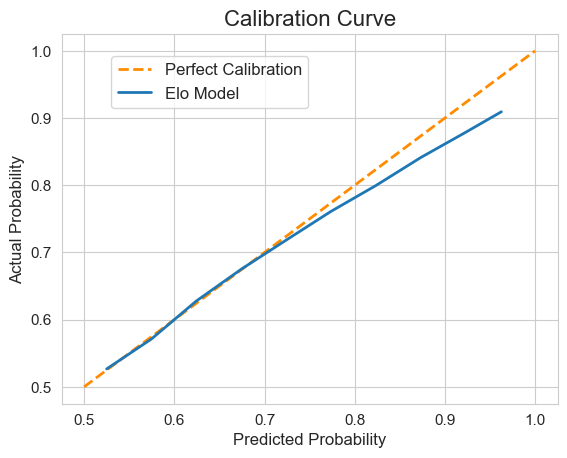

In [46]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(elo_record_df["predict"], elo_record_df["probability"], n_bins=20)
plt.plot([0.5, 1], [0.5, 1], linestyle="--", color="darkorange", linewidth=2, label="Perfect Calibration")
plt.plot(prob_pred, prob_true, linewidth=2, label="Elo Model")

plt.title("Calibration Curve", size=16)
plt.xlabel("Predicted Probability", size=12)
plt.xticks(size=11)
plt.ylabel("Actual Probability", size=12)
plt.yticks(size=11)

plt.legend(fontsize=12, loc=(0.1,0.8))
plt.show()

The model is calibrated pretty well.  It is accurate up to a win probability of 0.7 and then is overconfident when a team has a very strong chance to win.

In [47]:
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(elo_record_df["predict"], elo_record_df["probability"])
dummy_brier = brier_score_loss([1,0], [0.5,0.5])

print(f"The Brier Score measures the mean squared error of my predictions, and my result of {brier:.3f}, is better than the Brier Score {dummy_brier} of randomly guessing the result.")

print(f"This means that it reduces the error compared to randomly guessing by {(1-(brier/dummy_brier))*100:.2f}%")

The Brier Score measures the mean squared error of my predictions, and my result of 0.218, is better than the Brier Score 0.25 of randomly guessing the result.
This means that it reduces the error compared to randomly guessing by 12.78%


Given the good Calibration Curve, the relatively poor Brier score will be because the model is bad at separating wins from losses (it has a low resolution).

## Feature Importance Analysis

In [48]:
elo_constants.sort_values(by="Final Multiplier", ascending=False)

,scipy Multiplier,Intermediate Multiplier,Intermediate Additions,Final Multiplier
k,1.907996,35,0.0,66.779857
bsa,1.007662,23,0.0,23.176233
before_mid_adj,1.425287,1,0.0,1.425287
before_jng_adj,1.392431,1,0.0,1.392431
before_top_adj,1.334311,1,0.0,1.334311
before_team_adj,1.282324,1,0.0,1.282324
after_bot_adj,1.256877,1,0.0,1.256877
before_sup_adj,1.137267,1,0.0,1.137267
after_sup_adj,1.052336,1,0.0,1.052336
after_team_adj,0.998271,1,0.0,0.998271


Because each player and champion has 2 adjusting multipliers, we can multiply these together to find the total impact of each individual player, and champion.

However, due to the team_year_adj being 3x larger than the player_year_adj, after_team_adj will be slightly inflated compared to the after player adjusters.

Therefore, I have also found the Component Importance through multiplying the before multiplier by the standard deviation of components (to take into account both the after adjusters and year adjusters).

In [49]:
component_importance = pd.DataFrame(columns=["Component Importance", "Combined Final Multiplier"])
for pos in positions:
    component_importance.loc[pos, "Component Importance"] = pd.concat([elo_record_df[f'win_{pos}_elo'], elo_record_df[f'lose_{pos}_elo']], ignore_index=True).std() * elo_constants.loc[f'before_{pos}_adj', 'Final Multiplier']

    component_importance.loc[pos, "Combined Final Multiplier"] = elo_constants.loc[f"before_{pos}_adj", "Final Multiplier"] * elo_constants.loc[f"after_{pos}_adj", "Final Multiplier"]

component_importance /= component_importance.sum()
component_importance.sort_values(by="Component Importance", ascending=False)

,Component Importance,Combined Final Multiplier
mid,0.197205,0.185604
sup,0.177668,0.170679
bot,0.175286,0.172539
jng,0.163485,0.15932
team,0.148741,0.182561
top,0.137614,0.129297


Mid and Bot are the most important positions, which I would expect from our exploratory data analysis of the different roles of champions given that they have the most damage and the most kills.

They are followed by Support, and Jungle, who have a non-damage focused impact on their team's success.

Then, the team, which represents the organisation's structure and culture.

Finally, the Top position, which is notably less important than all the other positions.  This is most likely because it is isolated from much of the fightin on the map that happens on the bottom side.

## Model Error Analysis

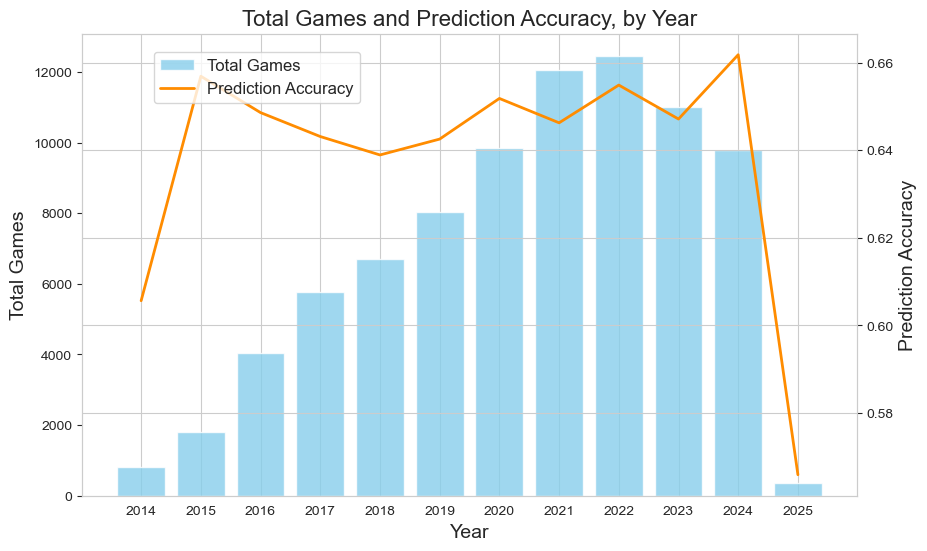

In [50]:
games_each_year = elo_record_df.groupby("year").size()

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(games_each_year.index,
        games_each_year.values,
        label="Total Games",
        color="skyblue",
        alpha=0.8)

plt.xticks(range(2014,2026,1))
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Total Games", fontsize=14)
ax1.grid(False, axis="y")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth=2)

ax2.set_ylabel("Prediction Accuracy", fontsize=14)

plt.title("Total Games and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1, fontsize=12)

plt.show()

2014, the first year, with the least data to train on, has the lowest prediction accuracy.

We can see a general trend for the prediction accuracy being higher in 2020 to 2024 than in the 4 years previously.

This somewhat correlates to the number of games played per year.  Although, I suspect that this will be influenced also by the number of new teams playing each year.

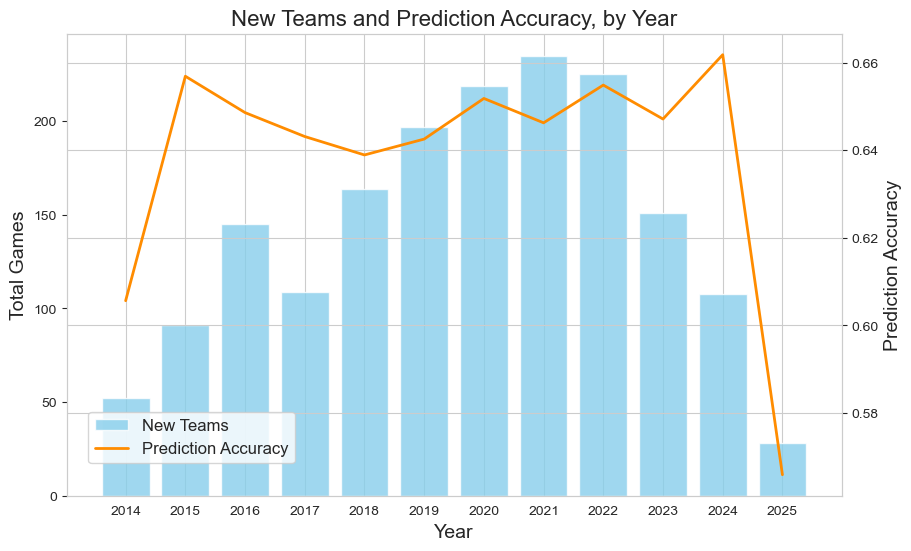

In [51]:
new_teams_each_year = (elo_record_df.loc[elo_record_df["team_win_teamid"].drop_duplicates().index,"year"]
                       .value_counts()
                       .sort_index())

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(new_teams_each_year.index,
        new_teams_each_year.values,
        label="New Teams",
        color="skyblue",
        alpha=0.8)

plt.xticks(range(2014,2026,1))
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Total Games", fontsize=14)
ax1.grid(False, axis="y")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth=2)

ax2.set_ylabel("Prediction Accuracy", fontsize=14)

plt.title("New Teams and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.25, 0.15), ncol=1, fontsize=12)

plt.show()

We can see that 2024 and 2023 had fewer new teams than the years preceding them.

We can also see that the number of new teams per year increases less steeply than the number of games per year.

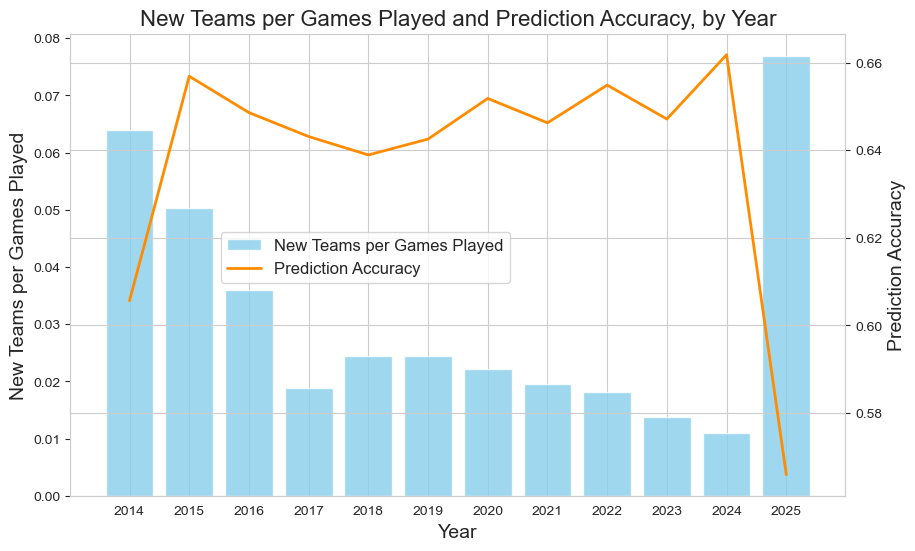

In [52]:
new_teams_per_games_played = new_teams_each_year / games_each_year

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(new_teams_per_games_played.index,
        new_teams_per_games_played.values,
        label="New Teams per Games Played",
        color="skyblue",
        alpha=0.8)

plt.xticks(range(2014,2026,1))
ax1.set_ylabel("New Teams per Games Played", fontsize=14)
ax1.set_xlabel("Year", fontsize=14)
ax1.grid(False, axis="y")

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth = 2)

ax2.set_ylabel("Prediction Accuracy", fontsize=14)

plt.title("New Teams per Games Played and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.42, 0.45), ncol=1, fontsize=12)

plt.show()

When we look at thebar chart of New Teams per Games Played, it appears to better explain the variations in Prediction Accuracy.

It makes sense that the less games the elo system has to adjust to new teams, the worse it will be at predicting their results.

In [53]:
print(f"We can confirm this by looking at the r value of new teams per games played and the prediction accuracy: {pd.DataFrame({'new_teams_per_games_played':new_teams_per_games_played, 'prediction_accuracy':elo_record_df.groupby('year')['predict'].mean()}).corr().iloc[0,1]}")

We can confirm this by looking at the r value of new teams per games played and the prediction accuracy: -0.8221741605956325


An r value of -0.82 shows very strong negative correlation.

I will also look at the differences between the different leagues through the elo system.

In [54]:
# Reading in the dflol file.
dflol = pd.read_pickle("dflol.pkl")

# Merging the 2 dataframes together.
elo_with_league = elo_record_df.merge(dflol.loc[dflol["participantid"] == 100, "league"], on="gameid")

# Finding the mean elo per game for each league.
mean_elo_by_league = elo_with_league.groupby(["league", "year"])[["win_total_elo", "lose_total_elo"]].mean()

In [55]:
(mean_elo_by_league["win_total_elo"] + mean_elo_by_league["lose_total_elo"])\
    .rename("mean elo per game")\
    .nlargest(20)

league  year
MSI     2024    23619.840024
        2023    23534.698773
EWC     2024    23517.967849
MSI     2022    23431.456263
        2021    23406.682368
WLDs    2024    23403.658834
MSI     2018    23332.562238
WLDs    2022    23306.835154
        2023    23303.796179
MSC     2020    23299.668559
MSI     2019    23295.737763
WLDs    2021    23291.753258
MSI     2017    23271.880103
WLDs    2020    23239.905956
        2019    23228.878417
AC      2024    23212.394350
WLDs    2017    23205.696093
        2018    23198.514568
        2016    23182.971823
MSI     2016    23165.083348
Name: mean elo per game, dtype: float64

The leagues with the highest mean elo are international tournaments where only the best teams from each region qualify (AC, EWC, MSI, & WLDs).

We can also see that the mean elo is larger for more recent tournaments, suggesting that the elo system hasn't plateaued yet and with more time will still have room to improve.

We can test this by looking at the calibration curve and brier score on temporal chunks of data, to see if the longer the elo system has run for, the better it will calibrate to games where a team has a high actual probability of winning.

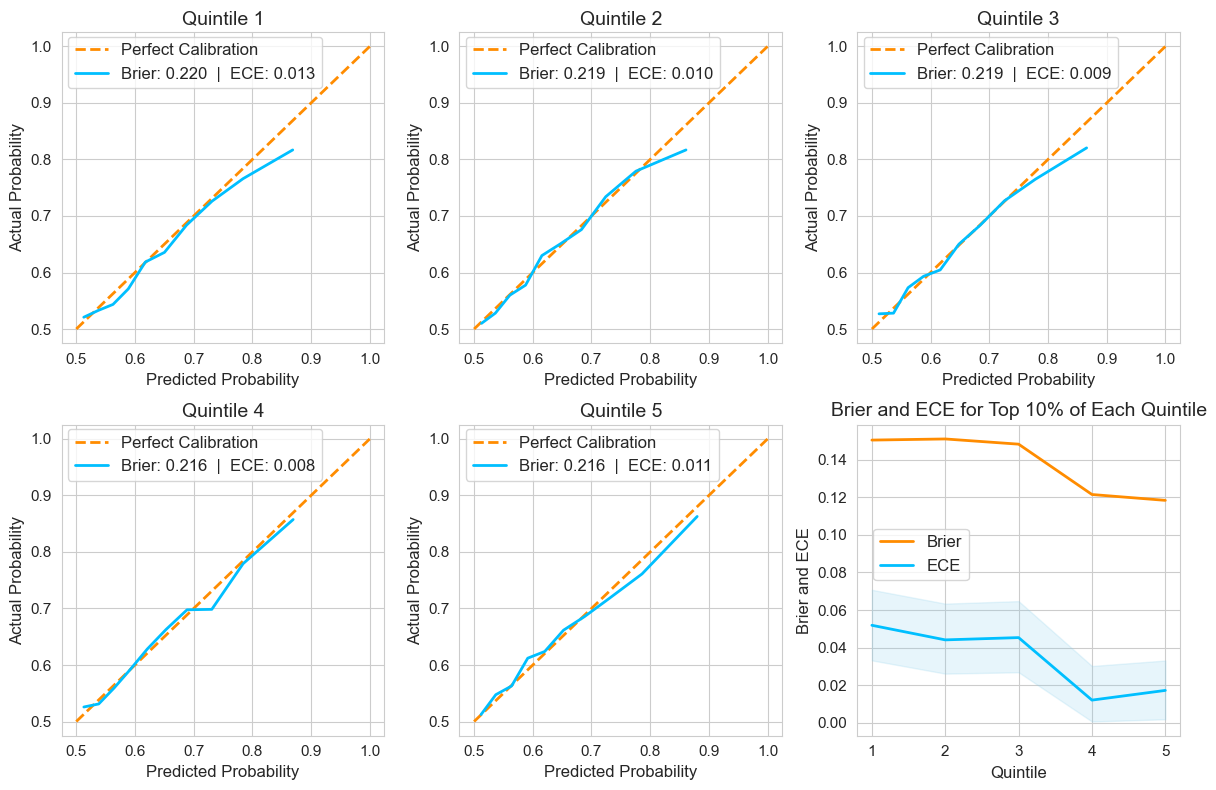

In [56]:
calibration_df = pd.DataFrame(columns=["Brier", "ECE", "Actual Probability", "Predicted Probability", "Low", "High"])

chunks = np.array_split(elo_record_df, 5)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, chunk in enumerate(chunks):
    ax = axes[i]

    # Calculate Brier and ECE
    brier = brier_score_loss(chunk["predict"], chunk["probability"])

    bin_edges = np.linspace(0, 1, 11)
    bin_id    = np.digitize(chunk["probability"], bin_edges) - 1
    ece       = 0
    for k in range(10):
        m = bin_id == k
        if m.any():
            ece += np.abs(chunk.loc[m, "probability"].mean() - chunk.loc[m, "predict"].mean()) * m.mean()

    # Calculate statistics for 9th quantile (top10%)
    p90      = np.quantile(chunk["probability"], 0.9)
    chunk_90 = chunk["probability"] >= p90
    brier_90 = brier_score_loss(chunk.loc[chunk_90, "predict"], chunk.loc[chunk_90, "probability"])
    ece_90   = abs(chunk.loc[chunk_90, "probability"].mean() - chunk.loc[chunk_90, "predict"].mean())

    # Using Bootstrapping to calculate a confidence interval.
    def ece_90_ci(chunk_90, iters=2000):
        n = len(chunk_90)
        ece_90_list = []
        for _ in range(iters):
            # Random Replacement Sampling.
            random_index = np.random.randint(0, n, n)
            ece_90_list.append(abs(chunk_90["probability"].values[random_index].mean() - chunk_90["predict"].values[random_index].mean()))
        return np.percentile(ece_90_list, [2.5, 97.5])

    low, high = ece_90_ci(chunk.loc[chunk_90])

    # Calculate Calibration Curve
    prob_true, prob_pred = calibration_curve(chunk["predict"],
                                             chunk["probability"],
                                             strategy="quantile",
                                             n_bins=10)
    # Record values in DataFrame
    calibration_df.loc[i+1] = [brier_90, ece_90, prob_true[-1], prob_pred[-1], low, high]

    # Plot 5 Chunk Graphs
    ax.plot([0.5, 1], [0.5, 1], "--", linewidth=2, color="darkorange", label="Perfect Calibration")
    ax.plot(prob_pred, prob_true, linewidth=2, color="deepskyblue", label=f"Brier: {brier:.3f}  |  ECE: {ece:.3f}")

    ax.set_title(f"Quintile {i+1}", size=14)
    ax.set_xlabel("Predicted Probability", size=12)
    ax.set_ylabel("Actual Probability",   size=12)
    ax.tick_params(labelsize=11)
    ax.legend(fontsize=12, loc=(0.02,0.82))

# Plot analysis of top 10%
ax = axes[5]
ax.plot(range(1, 6), calibration_df["Brier"], color="darkorange", linewidth=2, label="Brier")
ax.plot(range(1, 6), calibration_df["ECE"], linewidth=2, color="deepskyblue", label="ECE")
ax.fill_between(range(1, 6), calibration_df["Low"], calibration_df["High"], color="skyblue", alpha=0.2)

ax.set_title("Brier and ECE for Top 10% of Each Quintile", size=14)
ax.set_xlabel("Quintile", size=12)
ax.set_ylabel("Brier and ECE", size=12)
ax.tick_params(labelsize=11)
ax.legend(fontsize=12, loc=(0.05,0.5))

fig.tight_layout()

plt.show()

In [57]:
# Dataframe for the analysis of the top 10% of the games for each Quintile
calibration_df

,Brier,ECE,Actual Probability,Predicted Probability,Low,High
1,0.150323,0.051903,0.816918,0.868822,0.033251,0.070750
2,0.150917,0.044149,0.816918,0.861068,0.026214,0.063402
3,0.148153,0.045357,0.820544,0.865900,0.026944,0.064742
4,0.121400,0.012141,0.857402,0.869543,0.000765,0.030262
5,0.118290,0.017298,0.862840,0.880138,0.001970,0.033177


Whilst, for the range of probabilities over the 5 quintiles, there is only a slight improvement in the total Brier and virtually no improvement for ECE, when we look at only the top 10% of predicted probabilities, we can see the model improving over time.  It's ECE drops from 0.05 to 0.017 and its Brier falls from 0.15 to 0.12.

However, when we look at the predicted and actual probability of the games with a top 10% predicted probability, we can see that the predicted probability stays roughly even whilst the actual probability of those games increases significantly.  I believe that instead of the elo system continuing to adjust with time, teams have "grown into the model", in that teams are now able to consistently win 80%+ of their games, whereas the best teams could have been more inconsistent teams in the past.

I will analyse whether this change is statistically significant using bootstrapping.

In [58]:
chunk1 = chunks[0]
chunk5 = chunks[4]

chunk1_90 = chunk1["probability"] >= np.quantile(chunk1["probability"], 0.9)
chunk5_90 = chunk5["probability"] >= np.quantile(chunk5["probability"], 0.9)

# Bootstrapping to find a confidence interval for the difference between the first and last quintile.
def ece_diff_ci(c1, c1_90, c2, c2_90, iters=2000):
    len_c1_90 = c1_90.sum()
    len_c2_90 = c2_90.sum()
    ece_diff_list = []

    for _ in range(iters):
        random_index_1 = np.random.randint(0, len_c1_90, len_c1_90)
        random_index_2 = np.random.randint(0, len_c2_90, len_c2_90)
        ece_1_90 = abs(c1.loc[c1_90, "probability"].values[random_index_1].mean() - c1.loc[c1_90, "predict"].values[random_index_1].mean())
        ece_2_90 = abs(c2.loc[c2_90, "probability"].values[random_index_2].mean() - c2.loc[c2_90, "predict"].values[random_index_2].mean())
        ece_diff_list.append(ece_1_90 - ece_2_90)

    return np.percentile(ece_diff_list, [2.5, 97.5])

lower_bound, upper_bound = ece_diff_ci(chunk1, chunk1_90, chunk5, chunk5_90)

print(f"Lower Bound: {lower_bound:.4f}\nUpper Bound: {upper_bound:.4f}")
print(f"Actual Difference: {calibration_df.loc[1, 'ECE'] - calibration_df.loc[5, 'ECE']:.4f}")

Lower Bound: 0.0096
Upper Bound: 0.0588
Actual Difference: 0.0346


Because the lower bound of the confidence interval is above 0, I can confidently say that the decrease in ECE between the top 10% of predicted values in the first quintile and last quintile is statistically significant.
***

We can see that in international tournaments, that include teams from a variety of leagues, (AC, MSC, EWC & WLDs) are all in the bottom 20 leagues for prediction accuracy

Because the default elo ratings for each league are the same, despite some leagues being much higher in quality than others, a player may gain a very high elo rating in a lower league, and whilst this rating will be accurate for their league, if they move to a better league, the elo system will overestimate how good they are.

Ideally, there should be a record of each team's (and player's) home league and so there can be a league rating to properly adjust teams and players who move between leagues.  However, the available data does not include this information and therefore, these problems persist in my elo system.

In [59]:
elo_with_league.groupby(["league"])["predict"].mean()\
    .rename("Prediction Accuracy")\
    .nsmallest(20)

league
GSG       0.509434
MSC       0.520000
EWC       0.526316
TCS       0.536082
AOL       0.540541
AC        0.542857
HS        0.562500
NASG      0.564103
LCKC      0.589901
WLDs      0.598394
ESLOL     0.606971
LCSA      0.607232
LVP SL    0.607700
SLO       0.610063
EPL       0.610169
HC        0.610778
DL        0.611111
EU LCS    0.612613
PRM       0.613024
UGP       0.613636
Name: Prediction Accuracy, dtype: float64

# Conclusions
The main findings of this notebook include, but are not limited by:

The confirmation that the feasibility of the of creating an elo system to predict LoL games is possible.

That the elo system predicts games better when it has already been trained and developed ratings for the teams that are playing.

The players who play the game are a more important feature to predict the result than the organisation.

The most important position for predicting the result of a game is Mid.  The least important is Top.

The organisation/team that players play for is an important feature when predicting the result of games.

The elo system struggles when there are international tournaments because it combines several separate ecosystems without adjusting for the variation in strength of the leagues.

### Implications:
These results could be used by professional League of Legends teams to priorities the positions that most affect the result of games.  They could also be used by teams to find an approximation for the strength of opponents they face.

They can be used for betting companies to set and adjust odds as well as betters to make bets.

### Further Work:
 Further analysis could be done on which teams and players the elo system has the highest prediction accuracy for.

I will use the calculated elo ratings as a feature in my next notebook LoL_Predictions.

Further work could also be done to make an elo system that automatically updates by downloading recent game data and calculating the elo ratings for it to have an always up-to-date database of player and team ratings.